In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [187]:
class architecture:
    def __init__(self,input_size,hidden_list,batch_size,relu,mnsit):
        self.inp = input_size
        self.hl = hidden_list
        self.bs = batch_size
        self.wt_list = []
        self.delta_wt = []
        self.relu = relu
        self.hl.append(1)
        m = input_size+1
        for i in range(len(self.hl)):
            n = self.hl[i]
            if relu:
                wt_mat = (np.random.rand(m,n)-0.5) * 1e-5
            elif mnsit:
                wt_mat = (np.random.rand(m,n)-0.5) * 1e1
            else:
                wt_mat = (np.random.rand(m,n))
            delta_wt_mat = np.zeros((m,n))
            self.wt_list.append(wt_mat)
            self.delta_wt.append(delta_wt_mat)
            m = n+1
    def sigmoid(self,net_j):
        denom = 1 + np.exp(-1 * net_j)
        return (1.0/denom)
    def relu_fn(self,net_j):
        return np.maximum(np.zeros(np.shape(net_j)),net_j)
    def o_js_batch(self,input_x):
        opt_list = []
        opt_list.append(input_x)
        ipt_lyr = input_x
        for i in range(len(self.hl)):
            x0 = np.ones((len(ipt_lyr),1))
            ipt_lyr = np.hstack((ipt_lyr,x0))
            net_j = np.matmul(1.0 * ipt_lyr,self.wt_list[i])
            if self.relu and not (i == len(self.hl) - 1):
                o_j = self.relu_fn(net_j)
            else:
                o_j = self.sigmoid(net_j)
            opt_list.append(o_j)
            ipt_lyr = o_j
        return opt_list
    def o_js(self,input_x):
        ipt_lyr = np.asarray(input_x)
        ipt_lyr = np.matrix(ipt_lyr)
        return self.o_js_batch(ipt_lyr)
    def back_prop(self,o_js,y):
        num_elem = len(self.hl)
        delta_wt_rev = []
        final_opt = o_js[num_elem]
        delta_l = np.multiply((y - final_opt),np.multiply(final_opt,(1 - final_opt)))
        delta_l = np.transpose(delta_l)
        for i in range(num_elem):
            opp = num_elem-i
            o_j_prev = o_js[opp-1]
            x0 = np.ones((len(o_j_prev),1))
            o_j_prev = np.hstack((o_j_prev,x0))
            o_j_prev = np.transpose(o_j_prev)
            if i==0:
                delta_wt = -1 * np.matmul(o_j_prev,np.transpose(delta_l))
                delta_wt_rev.append(delta_wt)
                continue
            o_j = o_js[opp]
            if self.relu:
                g_o_j = 1.0 * (o_j >= 0) 
            else:
                g_o_j = np.multiply((1 - o_j),o_j)
            theta_lj = self.wt_list[opp]
            delta_l_theta_lj = np.matmul(theta_lj[0:-1],delta_l)
            new_net_j = -1 * np.multiply(delta_l_theta_lj,np.transpose(g_o_j))
            delta_l = -1 * new_net_j
            delta_wt = np.matmul(o_j_prev,np.transpose(new_net_j))
            delta_wt_rev.append(delta_wt)
        delta_wt_rev.reverse()
        return delta_wt_rev
    def train(self,train_x,train_y,epoch_count,learn_rate_const,fixed,stopping):
        batch_size = self.bs
        iterr = 0
        error_old = 0
        while iterr < epoch_count:
            error_here = 0
            if fixed:
                learn_rate = learn_rate_const
            else:
                learn_rate = learn_rate_const/(1.0 * math.sqrt(iterr+1))
            for i in range(len(train_x)):
                if (i%batch_size == 0) :
                    end_point = min(i+batch_size,len(train_x)-1)
                    inp_x = train_x[i:end_point]
                    inp_y = train_y[i:end_point]
                    y1 = np.asarray(inp_y)
                    y1 = np.matrix(y1)
                    inp_y = np.transpose(y1)
                    o_js_list = self.o_js_batch(inp_x)
                    self.delta_wt = self.back_prop(o_js_list,inp_y)
                    final_o = o_js_list[len(self.hl)]
                    error_here += (0.5) * np.matmul(np.transpose(inp_y-final_o),(inp_y-final_o))
                    for j in range(len(self.wt_list)):
                        self.wt_list[j] -= ((learn_rate) * self.delta_wt[j])
                else:
                    continue
            iterr +=1
            if (abs(error_old-error_here) < stopping) and (not iterr==0):
                print (error_old,error_here)
                return
            error_old = error_here
            if iterr%50 == 0:
                print (error_here)
                print ("epoch_no",iterr,self.accuracy(train_x,train_y))
    def output_single(self,o_js):
        out = o_js[len(self.hl)][0][0]
        return out
    def output(self,predicted_y):
        bool_pred = []
        for i in range(len(predicted_y)):
            bool_pred.append(predicted_y[i]>=0.5)
        return bool_pred
    def accuracy_(self,predicted_y,actual_y):
        counter=0
        for i in range(len(predicted_y)):
            if predicted_y[i]==actual_y[i]:
                counter+=1
        return ((counter*1.0)/len(predicted_y))
    def accuracy(self,X,Y):
        y = []
        for i in range(len(X)):
            out = self.o_js(X[i])
            y.append(self.output_single(out))
        predicted_y = self.output(y)
        accur = self.accuracy_(predicted_y,Y)
        return (accur) 
    def predict(self,X):
        y = []
        out = self.o_js(X)
        last_elem = out[len(self.hl)]
        predicted_y = self.output(last_elem)
        return np.asarray(predicted_y)

In [142]:
X = np.genfromtxt('../dataset/toy_trainX.csv',delimiter = ',') # list of training example vectors
Y = np.genfromtxt('../dataset/toy_trainY.csv',delimiter = ',') # list of training example vectors
test_X = np.genfromtxt('../dataset/toy_testX.csv',delimiter = ',') # list of training example vectors
test_Y = np.genfromtxt('../dataset/toy_testY.csv',delimiter = ',') # list of training example vectors


In [54]:
toy_train = architecture(2,[5],len(X),0,0)

In [55]:
bef_acc = toy_train.accuracy(X,Y)   
print (bef_acc)

0.505263157895


In [56]:
toy_train.train(X,Y,500,0.1,1,0)

[[52.3391435]]
('epoch_no', 50, 0.631578947368421)
[[26.40528959]]
('epoch_no', 100, 0.8289473684210527)
[[21.10793277]]
('epoch_no', 150, 0.8763157894736842)
[[19.75082295]]
('epoch_no', 200, 0.8868421052631579)
[[19.05156132]]
('epoch_no', 250, 0.8894736842105263)
[[18.6147196]]
('epoch_no', 300, 0.8921052631578947)
[[18.31176642]]
('epoch_no', 350, 0.8894736842105263)
[[18.08619801]]
('epoch_no', 400, 0.8894736842105263)
[[17.91034335]]
('epoch_no', 450, 0.8894736842105263)
[[17.76768426]]
('epoch_no', 500, 0.8894736842105263)


In [22]:
aft_acc = toy_train.accuracy(X,Y)
print (aft_acc)

0.886842105263


In [23]:
test_accur = toy_train.accuracy(test_X,test_Y)
print (test_accur)

0.883333333333


In [24]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X,Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
predictions = logisticRegr.predict(X)
predictions_test = logisticRegr.predict(test_X)
train_accur = toy_train.accuracy_(predictions,Y)
test_accur = toy_train.accuracy_(predictions_test,test_Y)
print (train_accur,test_accur)

(0.45789473684210524, 0.38333333333333336)


In [57]:
def plot_decision_boundary(model, X, y,name):
    """
    Given a model(a function) and a set of points(X), corresponding labels(y), scatter the points in X with color coding
    according to y. Also use the model to predict the label at grid points to get the region for each label, and thus the 
    descion boundary.
    Example usage:
    say we have a function predict(x,other params) which makes 0/1 prediction for point x and we want to plot
    train set then call as:
    plot_decision_boundary(lambda x:predict(x,other params),X_train,Y_train)
    params(3): 
        model : a function which expectes the point to make 0/1 label prediction
        X : a (mx2) numpy array with the points
        y : a (mx1) numpy array with labels
    outputs(None)
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.05
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.title(name)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.savefig("../output/" + name + ".jpg")

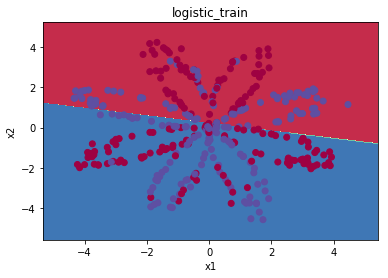

In [58]:
plot_decision_boundary(lambda x:logisticRegr.predict(x),X,Y,"logistic_train")

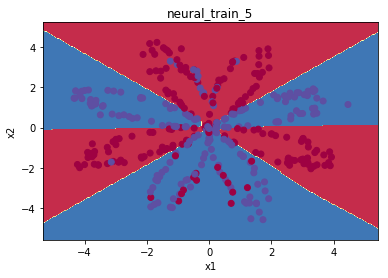

In [59]:
plot_decision_boundary(lambda x:toy_train.predict(x),X,Y,"neural_train_5")

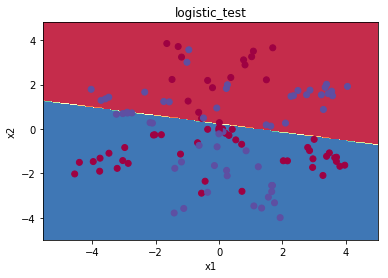

In [60]:
plot_decision_boundary(lambda x:logisticRegr.predict(x),test_X,test_Y,"logistic_test")

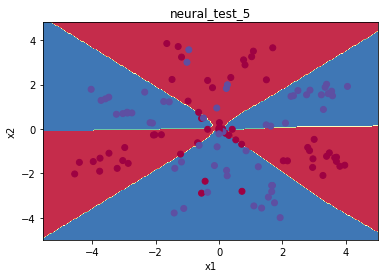

In [61]:
plot_decision_boundary(lambda x:toy_train.predict(x),test_X,test_Y,"neural_test_5")

In [62]:
units = [1,2,3,10,20,40]

[[53.97485322]]
('epoch_no', 50, 0.5052631578947369)
[[48.90977998]]
('epoch_no', 100, 0.5842105263157895)
[[46.59660397]]
('epoch_no', 150, 0.5947368421052631)
[[45.85049771]]
('epoch_no', 200, 0.6)
[[45.48567319]]
('epoch_no', 250, 0.6)
[[45.26813647]]
('epoch_no', 300, 0.6)
[[45.12409525]]
('epoch_no', 350, 0.6)
[[45.02096418]]
('epoch_no', 400, 0.6026315789473684)
[[44.9416415]]
('epoch_no', 450, 0.6026315789473684)
[[44.87696992]]
('epoch_no', 500, 0.6026315789473684)
[[44.82219589]]
('epoch_no', 550, 0.6026315789473684)
[[44.77477319]]
('epoch_no', 600, 0.6026315789473684)
[[44.73316125]]
('epoch_no', 650, 0.6026315789473684)
[[44.6962918]]
('epoch_no', 700, 0.6026315789473684)
[[44.66335908]]
('epoch_no', 750, 0.6026315789473684)
[[44.63373227]]
('epoch_no', 800, 0.6026315789473684)
[[44.60690916]]
('epoch_no', 850, 0.6026315789473684)
[[44.58248554]]
('epoch_no', 900, 0.6026315789473684)
[[44.56013271]]
('epoch_no', 950, 0.6026315789473684)
[[44.53958074]]
('epoch_no', 1000, 0.

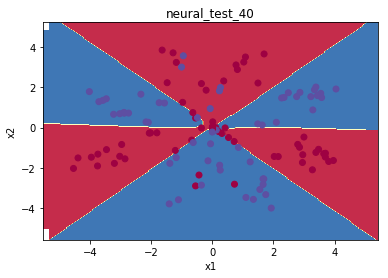

In [88]:
for i in range(len(units)):
    toy_train = architecture(2,[units[i]],len(X),0,0)
    toy_train.train(X,Y,1000,0.1,1,0)
    aft_acc = toy_train.accuracy(X,Y)
    print ("train accuracy ", units[i],aft_acc)
    test_accur = toy_train.accuracy(test_X,test_Y)
    print ("test accuracy ", units[i],test_accur)
    plot_decision_boundary(lambda x:toy_train.predict(x),X,Y,"neural_train_"+(str)(units[i]))
    plot_decision_boundary(lambda x:toy_train.predict(x),test_X,test_Y,"neural_test_"+(str)(units[i]))    

[[54.24421007]]
('epoch_no', 50, 0.49473684210526314)
[[53.77386071]]
('epoch_no', 100, 0.49473684210526314)
[[49.77713807]]
('epoch_no', 150, 0.5763157894736842)
[[45.90521265]]
('epoch_no', 200, 0.6236842105263158)
[[44.84249773]]
('epoch_no', 250, 0.6236842105263158)
[[42.01393388]]
('epoch_no', 300, 0.6026315789473684)
[[25.19266013]]
('epoch_no', 350, 0.8473684210526315)
[[22.39307954]]
('epoch_no', 400, 0.868421052631579)
[[21.4602116]]
('epoch_no', 450, 0.8710526315789474)
[[20.90995918]]
('epoch_no', 500, 0.8710526315789474)
[[20.50294239]]
('epoch_no', 550, 0.8736842105263158)
[[20.16626676]]
('epoch_no', 600, 0.8736842105263158)
[[19.86561293]]
('epoch_no', 650, 0.8763157894736842)
[[19.58213829]]
('epoch_no', 700, 0.8763157894736842)
[[19.31357883]]
('epoch_no', 750, 0.8789473684210526)
[[19.06744688]]
('epoch_no', 800, 0.8789473684210526)
[[18.84275533]]
('epoch_no', 850, 0.8789473684210526)
[[18.63461146]]
('epoch_no', 900, 0.8789473684210526)
[[18.44501566]]
('epoch_no', 

('epoch_no', 7900, 0.9078947368421053)
[[13.14488729]]
('epoch_no', 7950, 0.9078947368421053)
[[13.19777081]]
('epoch_no', 8000, 0.9078947368421053)
[[13.17766936]]
('epoch_no', 8050, 0.9078947368421053)
[[13.04451107]]
('epoch_no', 8100, 0.9078947368421053)
[[12.9741084]]
('epoch_no', 8150, 0.9078947368421053)
[[12.98406244]]
('epoch_no', 8200, 0.9078947368421053)
[[13.0770809]]
('epoch_no', 8250, 0.9078947368421053)
[[13.1950566]]
('epoch_no', 8300, 0.9078947368421053)
[[12.98502286]]
('epoch_no', 8350, 0.9078947368421053)
[[12.95636575]]
('epoch_no', 8400, 0.9078947368421053)
[[13.11860768]]
('epoch_no', 8450, 0.9078947368421053)
[[12.98273157]]
('epoch_no', 8500, 0.9078947368421053)
[[12.96351811]]
('epoch_no', 8550, 0.9078947368421053)
[[13.18381012]]
('epoch_no', 8600, 0.9078947368421053)
[[12.92145396]]
('epoch_no', 8650, 0.9078947368421053)
[[13.14750407]]
('epoch_no', 8700, 0.9078947368421053)
[[12.97401718]]
('epoch_no', 8750, 0.9078947368421053)
[[12.87475994]]
('epoch_no', 

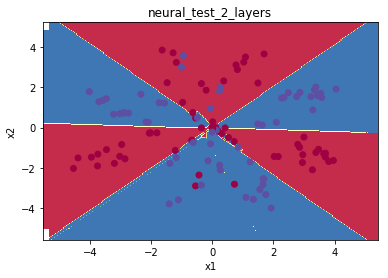

In [95]:
toy_train = architecture(2,[5,5],len(X),0,0)
toy_train.train(X,Y,10000,0.1,1,0)
aft_acc = toy_train.accuracy(X,Y)
print ("train accuracy 2 layer",aft_acc)
test_accur = toy_train.accuracy(test_X,test_Y)
print ("test accuracy 2 layer",test_accur)
plot_decision_boundary(lambda x:toy_train.predict(x),X,Y,"neural_train_2_layers")
plot_decision_boundary(lambda x:toy_train.predict(x),test_X,test_Y,"neural_test_2_layers")    

In [143]:
X = np.genfromtxt('../dataset/MNIST_train.csv',delimiter = ',',dtype='float32') # list of training example vectors
Y = 1 * (X[:,len(X[0])-1] == 6)
X = np.delete(X,len(X[0])-1,1)
X = X/255
test_X = np.genfromtxt('../dataset/MNIST_test.csv',delimiter = ',',dtype = 'float32') # list of training example vectors
test_Y = 1 * (test_X[:,len(test_X[0])-1]==6)
test_X = np.delete(test_X,len(test_X[0])-1,1)
test_X = test_X/255

In [105]:
digit = architecture(len(X[0]),[],100,0,1)

In [106]:
bef_acc = digit.accuracy(X,Y)
print ("train accuracy ",bef_acc)
digit.train(X,Y,200,1,1,0)
aft_acc = digit.accuracy(X,Y)
print ("train accuracy ",aft_acc)
test_accur = digit.accuracy(test_X,test_Y)
print ("test accuracy ",test_accur)

('train accuracy ', 0.6132)
[[27.2514495]]
('epoch_no', 50, 0.9725)
[[19.76743992]]
('epoch_no', 100, 0.9833)
[[17.02904694]]
('epoch_no', 150, 0.9912)
[[14.22958331]]
('epoch_no', 200, 0.9947)
('train accuracy ', 0.9947)
('test accuracy ', 0.9888888888888889)


In [176]:
digit_new = architecture(len(X[0]),[100],100,0,1)

In [177]:
digit_new.train(X,Y,102,0.1,0,0.2)

[[61.64342809]]
('epoch_no', 50, 0.9865)
(matrix([[55.26828296]]), matrix([[55.07845519]]))


In [178]:
aft_acc = digit_new.accuracy(X,Y)
print ("train accuracy ",aft_acc)
test_accur = digit_new.accuracy(test_X,test_Y)
print ("test accuracy ",test_accur)

('train accuracy ', 0.989)
('test accuracy ', 0.9741666666666666)


In [214]:
digit_relu = architecture(len(X[0]),[100],100,1,0)

In [215]:
digit_relu.train(X,Y,51,0.01,0,0)

[[117.99339417]]
('epoch_no', 50, 0.9725)


In [216]:
aft_acc = digit_relu.accuracy(X,Y)
print ("train accuracy ",aft_acc)
test_accur = digit_relu.accuracy(test_X,test_Y)
print ("test accuracy ",test_accur)

('train accuracy ', 0.9727)
('test accuracy ', 0.9719444444444445)
